In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

np.random.seed(7)
torch.manual_seed(128)

In [2]:
# x: [n, 2], grid point coordinates
# mu: [d] Uniform([-1, -1]^d)
# return: [n] initial value for each grid point
def initial_condition(x, mu):
  d = mu.shape[0]
  n = x.shape[0]
  u_0 = torch.zeros((n))

  x_init = np.repeat(x, d, axis=0) * np.pi
  x_init = x_init.reshape(n, d, -1)
  for i in range(1, d+1, 1):
    x_init[:, i-1] *= i
  u = np.sin(x_init)
  for i in range(1, d+1, 1):
    u_0[:] += -u[:, i-1, 0] * u[:, i-1, 1]* mu[i-1] / i**0.5

  return u_0/d

# x: [n, 2], grid point coordinates
# mu: [d] Uniform([-1, -1]^d)
# return : [n] final value for each grid point
def final_value(x, mu, T):
  d = mu.shape[0]
  n = x.shape[0]
  u_T = torch.zeros((n))

  x_final = np.repeat(x, d, axis=0) * np.pi
  x_final = x_final.reshape(n, d, -1)
  for i in range(1, d+1, 1):
    x_final[:, i-1] *= i
  u = np.sin(x_final)
  for i in range(1, d+1, 1):
    u_T[:] += -u[:, i-1, 0] * u[:, i-1, 1]* mu[i-1] / i**0.5 * np.exp(-2.*(i*np.pi)**2*T)

  return u_T

def convert(tens, domain_extrema):
  assert (tens.shape[1] == domain_extrema.shape[0])
  return tens * (domain_extrema[:, 1] - domain_extrema[:, 0]) + domain_extrema[:, 0]

In [3]:
-0.5*(np.sin(np.pi*1)*np.sin(np.pi*2)*(-1)/1**0.5 + np.sin(2*np.pi*1)*np.sin(2*np.pi*2)*(1)/2**0.5), -0.5*(np.sin(np.pi*3)*np.sin(np.pi*4)*(-1)/1**0.5 + np.sin(2*np.pi*3)*np.sin(2*np.pi*4)*(1)/2**0.5)

(-5.741721032546107e-32, -3.4450326195276636e-31)

In [4]:
n_x = 600
d = 6
T = 0.1
domain_extrema = torch.tensor([[-1, 1], [-1, 1]]) # x in [-1, 1]^2
soboleng = torch.quasirandom.SobolEngine(dimension=domain_extrema.shape[0])
input_x = convert(soboleng.draw(n_x), domain_extrema)

mu = np.random.uniform(-1, 1, d)

In [6]:
print(soboleng.draw(n_x).shape)

torch.Size([600, 2])


In [6]:
u_0 = initial_condition(input_x, mu)
u_T = final_value(input_x, mu, T)
u_0.shape, u_T.shape

(torch.Size([600]), torch.Size([600]))

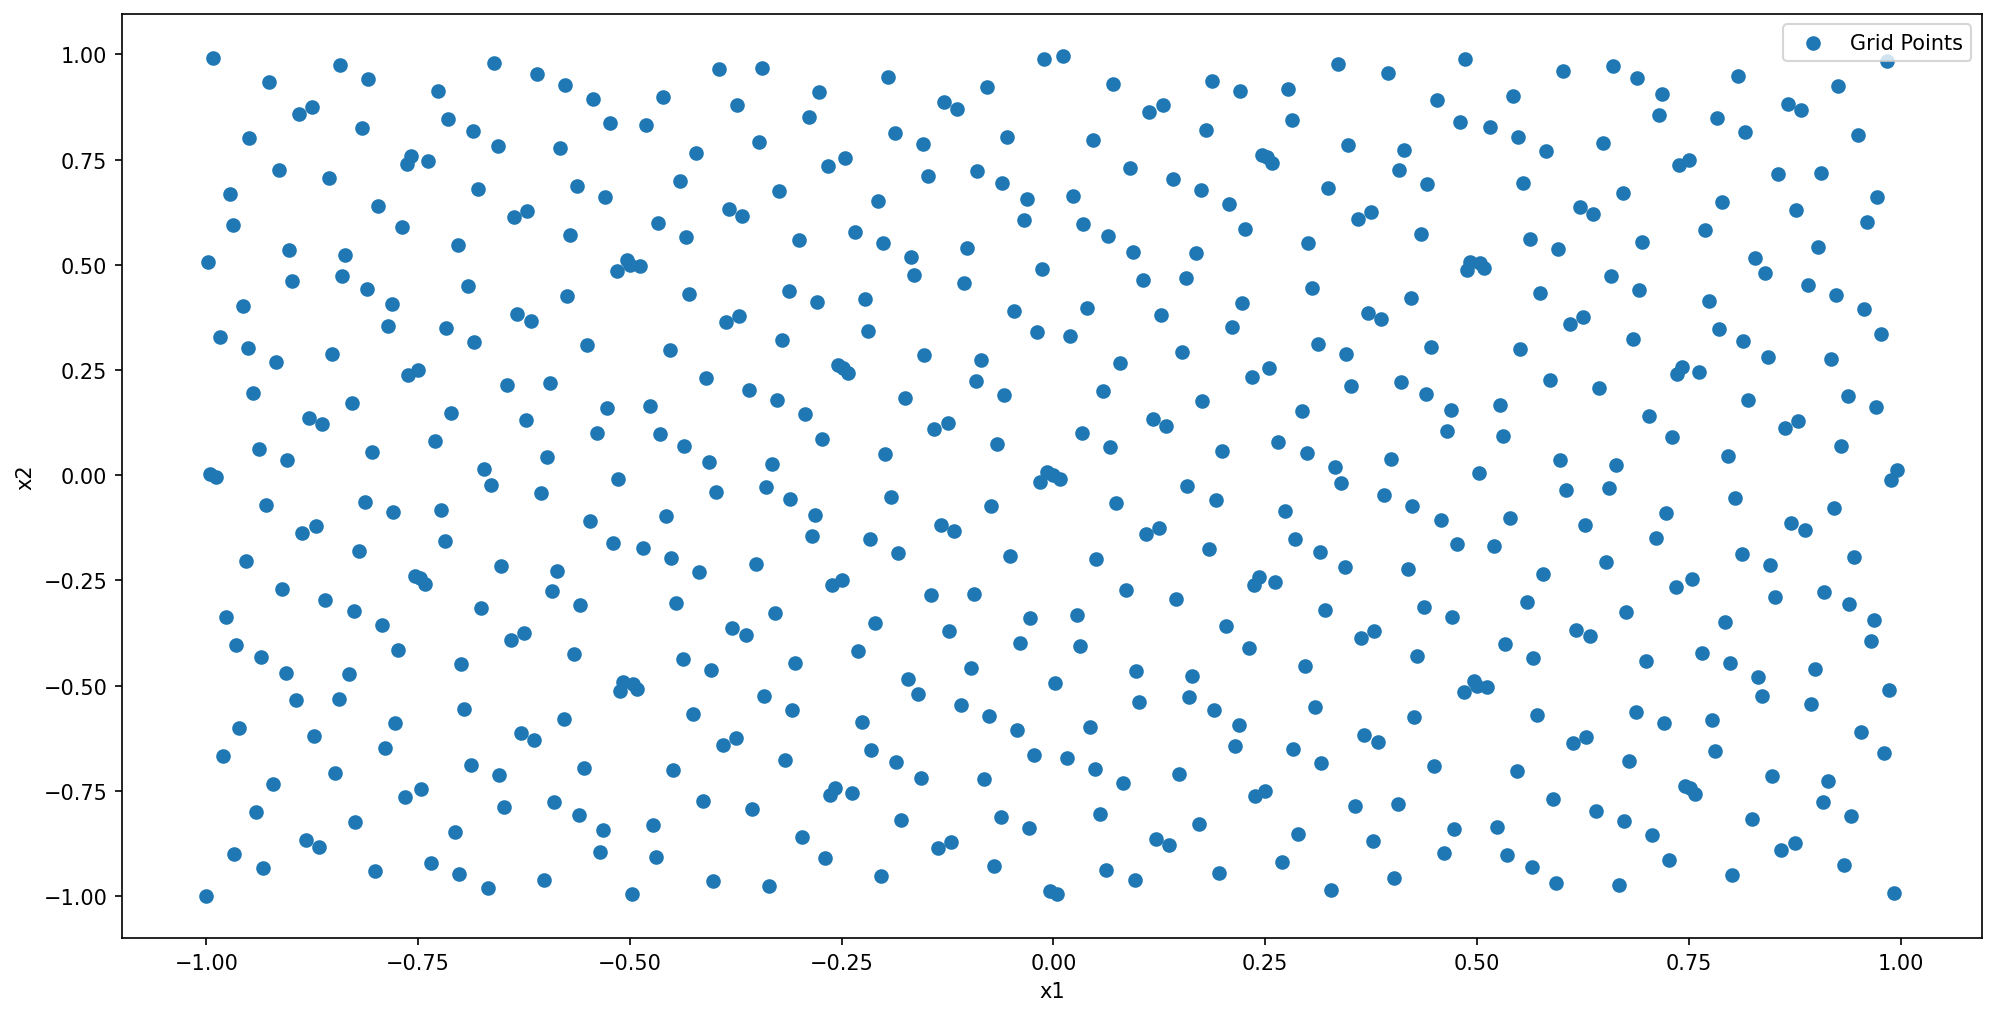

In [5]:
plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_x[:, 1].detach().numpy(), input_x[:, 0].detach().numpy(), label="Grid Points")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

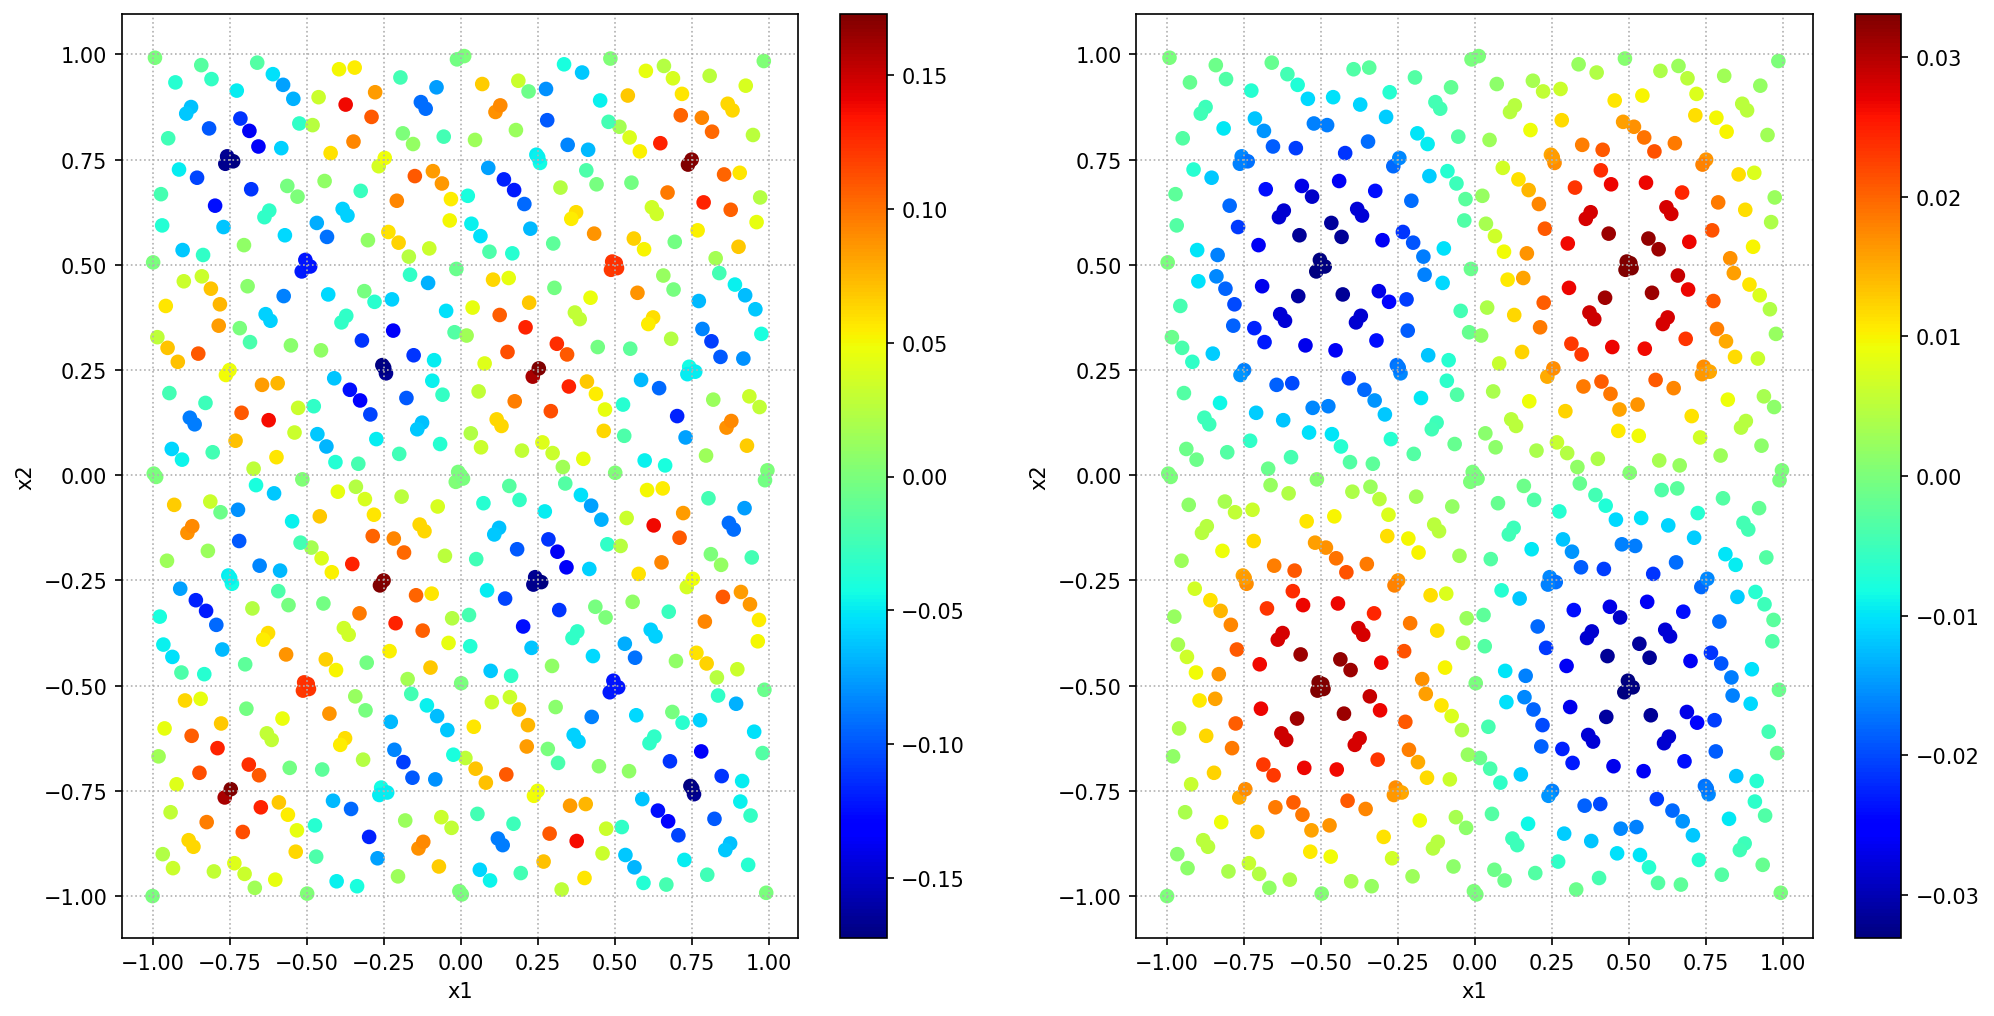

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].scatter(input_x[:, 1], input_x[:, 0], c=u_0, cmap="jet")
axs[0].set_xlabel("x1")
axs[0].set_ylabel("x2")
plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")
im2 = axs[1].scatter(input_x[:, 1], input_x[:, 0], c=u_T, cmap="jet")
axs[1].set_xlabel("x1")
axs[1].set_ylabel("x2")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
plt.show()

In [17]:
training_set = DataLoader(torch.utils.data.TensorDataset(u_0, u_T), batch_size=n_x, shuffle=False)